# Optimización de funciones
El objetivo de esta práctica es el de utilizar varios métodos de optimización para obtener los mínimos globales de alguna función, en este caso la función Shubert

Función Shubert:  
$$f(x, y) = \sum_{i=1}^{5} i \cdot \cos((i+1) \cdot x + i) \cdot \cos((i+1) \cdot y + i)$$
18 mínimos glbales ebn el rango x:[-10, 10] , y:[-10,10]  
Mínimo global: -186.7309

## Graficando función

In [12]:
#importar librerías necesarias
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
from numpy import*
import matplotlib.cm as cm

# Función shubert
def shubert(x1,x2):
    a=0
    b=0
    for i in range(1,6):
        a+=i*cos((i+1)*x1+i)
        b+=i*cos((i+1)*x2+i)
    return a*b


x1 = linspace(-10,10,200)   #generar 100 valores entre -2 y 2
x2 = linspace(-10,10,200)   
X1,X2 = meshgrid(x1,x2)   #generar la malla de valores
Z = shubert(X1,X2)   #evaluar la función en la malla de valores

# funcion para crear interactividad
def plotter(E,A):
    fig=plt.figure(figsize=[12,8])
    ax=plt.axes(projection='3d')
    norm = plt.Normalize(Z.min(), Z.max())  # normalizar los valores de Z para asignar colores
    colors = cm.rainbow(norm(Z))       # asignar colores a los valores de Z
    rcount, ccount, _ = colors.shape    # obtener el número de filas y columnas de la matriz de colores
    ax.plot_surface(X1,X2,Z,facecolors=colors, shade=False) #graficar la superficie
    ax.plot_wireframe(X1,X2,Z,ccount=2,rcount=2,color='pink', alpha=0.2)    #graficar la malla
    ax.view_init(elev=E,azim=A)  #ajustar la elevación y el ángulo de visión
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1,x2)')
    plt.show()

# Se crea la gráfica interactiva
from ipywidgets import interactive
iplot=interactive(plotter,E=(-90,90,5),A=(-90,90,5))    #crear el objeto interactivo
iplot   #mostrar el objeto interactivo

interactive(children=(IntSlider(value=0, description='E', max=90, min=-90, step=5), IntSlider(value=0, descrip…

## Solución con algoritmos genéticos

In [13]:
import random
import numpy as np

class AG():
    #Método inicializador
    def __init__(self, function, x_range, y_range, len_cromosoma) -> None:
        self.funcion = function #Función a optimizar
        self.x_min, self.x_max = x_range #Rango de valores para x
        self.y_min, self.y_max = y_range #Rango de valores para y
        self.len_cromosoma = len_cromosoma #Longitud del cromosoma

    #Método para generar un individuo
    def generar_individuo(self):
        individuo = [0]*self.len_cromosoma #Inicializamos el individuo con ceros de longitud len_cromosoma
        for i in range(self.len_cromosoma):
            r = random.randint(0,1) #Generamos un número aleatorio 0 o 1
            individuo[i] = r # se guarda en la posición i del individuo
        return individuo #Retornamos el individuo
    
    #Método para generar el valor decimal a partir del cromosoma
    def generar_decimal(self, individuo):
        mitad = int(self.len_cromosoma/2) #Calculamos la mitad de la longitud del cromosoma
        x_dec = sum([individuo[(mitad - 1) - i]*(2**i) for i in range(0, mitad)])  #Convertimos la primera mitad de la lista de bits a decimal para la variable X
        y_dec = sum([individuo[self.len_cromosoma - 1 -i]*(2**(i)) for i in range(0, mitad)]) #Convertimos la primera mitad de la lista de bits a decimal para la variable Y
        x = (x_dec/(2**(self.len_cromosoma/2)))*(self.x_max - self.x_min) + self.x_min #le asignamos un valor a x en el rango de x
        y = (y_dec/(2**(self.len_cromosoma/2)))*(self.y_max - self.y_min) + self.y_min #le asignamos un valor a y en el rango de y
        return x, y #Retornamos el valor de x y y
    
    #Método para calcular la aptitud de un individuo
    def calcular_aptitud(self, individuo):
        x, y = self.generar_decimal(individuo)
        return -self.funcion(x, y) # La aptitud es el valor de la función negativa

    #Método para seleccionar un individuo mediante el método de la ruleta
    def seleccion_ruleta(self, poblacion): 
        aptitudes = np.array([self.calcular_aptitud(individuo) for individuo in poblacion])
        total_aptitudes = np.sum(aptitudes)
        probabilidad_seleccion = aptitudes / total_aptitudes
        indice_seleccionado = np.random.choice(range(len(poblacion)), p=probabilidad_seleccion)
        return poblacion[indice_seleccionado]

    #Método para seleccionar un individuo mediante el método del torneo
    def seleccion_torneo(self,poblacion):
        torneo = random.sample(poblacion, 3)
        torneo.sort(key=lambda individuo: self.calcular_aptitud(individuo),reverse=True) #Ordenamos el torneo de mayor a menor aptitud
        return torneo[0] #Retornamos el mejor individuo del torneo

    #Método para realizar el cruce de un punto
    def crossover_un_punto(self, padre1, padre2):
        punto_corte = random.randint(0, len(padre1) - 1)
        hijo = np.concatenate((padre1[:punto_corte], padre2[punto_corte:]))
        return hijo
        
    #Método para realizar el cruce de dos puntos
    def crossover_dos_puntos(self,padre1, padre2):
        punto_corte1, punto_corte2 = sorted(random.sample(range(len(padre1)), 2))
        hijo = np.concatenate((np.concatenate((padre1[:punto_corte1], padre2[punto_corte1:punto_corte2])),padre1[punto_corte2:]))
        return hijo

    #Método para realizar la mutación de un individuo
    def mutacion(self, individuo):
        indice_mutacion = random.randint(0, len(individuo) - 1)
        individuo_mutado = individuo.copy()
        individuo_mutado[indice_mutacion] = 1 - individuo_mutado[indice_mutacion] #Cambiamos el bit en la posición indice_mutacion
        return individuo_mutado

    #Método para realizar el algoritmo genético
    def algoritmo_genetico(self, tamano_poblacion=100, generaciones=100, prob_mutacion=0.1):
        poblacion = [self.generar_individuo() for _ in range(tamano_poblacion)] #Generamos la población inicial
        i=0

        #for _ in range(generaciones):
        while i < generaciones:
            poblacion = sorted(poblacion, key=lambda individuo: self.calcular_aptitud(individuo), reverse=True) #Ordenamos la población de mayor a menor aptitud
            mejor_individuo = poblacion[0] 
            #print(f"\r{mejor_individuo}", end='', flush=True)


            nueva_poblacion = [] 

            while len(nueva_poblacion) < tamano_poblacion:
                # padre1 = self.seleccion_ruleta(poblacion)
                # padre2 = self.seleccion_ruleta(poblacion)
                padre1 = self.seleccion_torneo(poblacion)
                padre2 = self.seleccion_torneo(poblacion)

                hijo = self.crossover_dos_puntos(padre1, padre2)
                
                if random.random() < prob_mutacion:
                    hijo = self.mutacion(hijo)

                nueva_poblacion.append(hijo)

            poblacion = nueva_poblacion
            i+=1
            if self.calcular_aptitud(poblacion[0]) == 1:
                break

        mejor_individuo = poblacion[0]
        return self.generar_decimal(mejor_individuo), -self.calcular_aptitud(mejor_individuo), i, [-self.calcular_aptitud(individuo) for individuo in poblacion]


### Resolviendo función con algoritmo genéticos

In [14]:
# Se prueban varias longitudes de cromosomas
for len_cromosoma in [8, 12, 16, 20]:
    ag = AG(shubert, (-10, 10), (-10, 10), len_cromosoma) #se crea el objeto ag con los parámetros: función, rangox, rangoy, longitud_del_cromosoma
    solucion, f_evaluada, iteraciones, poblacion = ag.algoritmo_genetico() #se ejecuta el algoritmo genético
    print(f"longitud de cromosomas: {len_cromosoma}\nsolucion: {solucion}\niteraciones: {iteraciones}\nf(x1, x2): {f_evaluada}\n")

longitud de cromosomas: 8
solucion: (5.0, -5.0)
iteraciones: 100
f(x1, x2): -27.452999565459816

longitud de cromosomas: 12
solucion: (-7.1875, -7.8125)
iteraciones: 100
f(x1, x2): -142.24070792325944

longitud de cromosomas: 16
solucion: (-1.484375, 5.46875)
iteraciones: 100
f(x1, x2): -178.34147873764644

longitud de cromosomas: 20
solucion: (4.86328125, -7.08984375)
iteraciones: 100
f(x1, x2): -186.57840617380214



Se crea un histograma para cada longitud de cromosoma y así poder visualizar cuántos sujetos de la población final se acercaron a la solución real

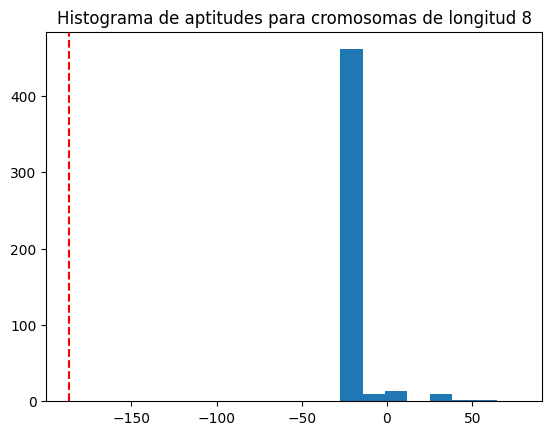

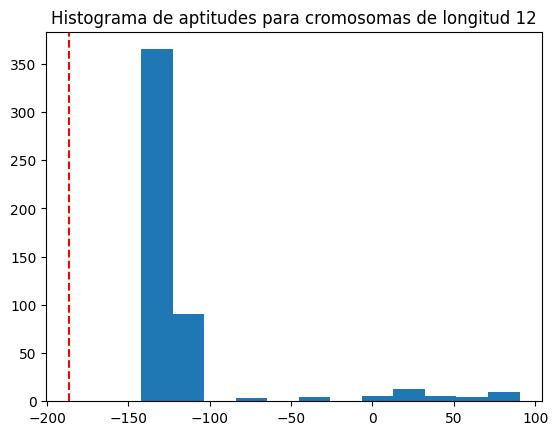

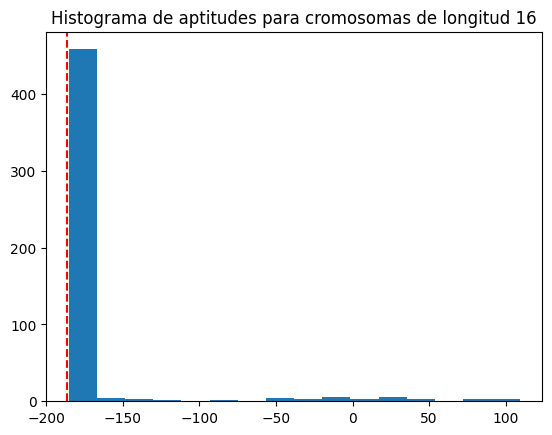

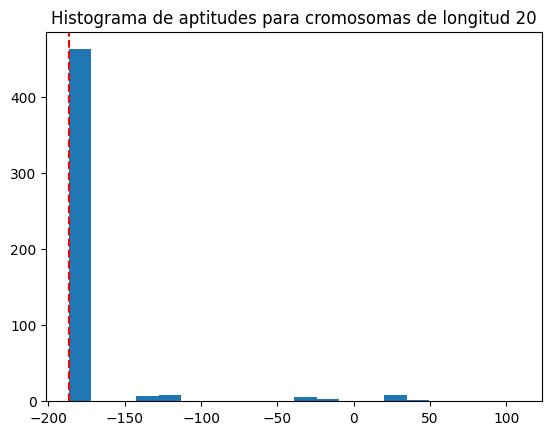

In [15]:
for len_cromosoma in [8, 12, 16, 20]:
    poblaciones = []
    for _ in range(5):
        ag = AG(shubert, (-10, 10), (-10, 10), len_cromosoma)
        solucion, f_evaluada, iteraciones, poblacion = ag.algoritmo_genetico()
        poblaciones = poblaciones + poblacion
    plt.hist(poblaciones, bins=len_cromosoma)
    plt.title(f"Histograma de aptitudes para cromosomas de longitud {len_cromosoma}")
    plt.axvline(x=-186.73, color='r', linestyle='--', label='Valor óptimo')
    plt.show()
        

## Solución con Recocido simulado

In [16]:
import random
import math

class SimulatedAnnealing():
    # Inicialización de los parámetros del algoritmo
    def __init__(self, funcion, x_range, y_range, temp_ini=1000, max_iter=10000, opcion='exponencial', factor_enfriamiento=0.95): 
        self.funcion = funcion # Función a optimizar
        self.x_min, self.x_max = x_range # Rango de valores para x
        self.y_min, self.y_max = y_range # Rango de valores para y
        self.temperatura_inicial = temp_ini # Temperatura inicial
        self.max_iteraciones = max_iter # Número máximo de iteraciones
        self.opcion = opcion  # Opción para el cambio de temperatura
        self.factor_enfriamiento = factor_enfriamiento # Factor de enfriamiento
        self.solucion_actual = self.genera_solucion_inicial() # Solución inicial

    # Generación de una solución inicial aleatoria
    def genera_solucion_inicial(self):
        return [random.uniform(self.x_min, self.x_max), random.uniform(self.y_min, self.y_max)]  


    # Cambio de temperatura
    def cambio_de_temperatura(self, temperatura_actual):
        if self.opcion == 'lineal':
            return temperatura_actual * (1 - self.factor_enfriamiento) 
        elif self.opcion == 'exponencial':
            return temperatura_actual * self.factor_enfriamiento 


    # Algoritmo de recocido simulado
    def recocido_simulado(self):
        solucion_actual = self.solucion_actual 
        valor_actual = self.funcion(solucion_actual[0], solucion_actual[1])  #se evalua la funcion en la solucion actual

        temperatura_actual = self.temperatura_inicial  #se inicializa la temperatura
       
        for i in range(self.max_iteraciones):
            vecino = [solucion + random.uniform(-0.5, 0.5) for solucion in solucion_actual]  #se genera un vecino de la solucion actual
            valor_vecino = self.funcion(vecino[0], vecino[1])  #se evalua la funcion en el vecino

            delta_valor = valor_vecino - valor_actual  #se calcula la diferencia de valor entre la solucion actual y el vecino
            if delta_valor < 0:  #si el vecino es mejor que la solucion actual, se acepta
                solucion_actual = vecino 
                valor_actual = valor_vecino
            else: 
                probabilidad_aceptacion = math.exp(-delta_valor / temperatura_actual) #si el vecino es peor que la solucion actual, se acepta con cierta probabilidad
                aleatorio = random.random() 
                if aleatorio < probabilidad_aceptacion: #se acepta el vecino con cierta probabilidad
                    solucion_actual = vecino 
                    valor_actual = valor_vecino

            temperatura_actual = self.cambio_de_temperatura(temperatura_actual) #se cambia la temperatura

        return solucion_actual, valor_actual 

### Solución usando recocido simulado

In [17]:
#calcular solucion
sa = SimulatedAnnealing(shubert, (-10, 10), (-10, 10)) 
solucion, f_evaluada = sa.recocido_simulado()
print(f"Solución: {solucion}\nf(x1, x2) = {f_evaluada}")

Solución: [-1.4231743610865313, 5.479870604411127]
f(x1, x2) = -186.70219340080706


# Solución con Beam search

In [18]:
import random

class BeamSearch():
    # Inicializando los parámetros
    def __init__(self, func, x_range, y_range, beam_width=10, max_iter=1000):
        self.func = func  # Funcion a optimizar
        self.x_min, self.x_max = x_range  # Range of values for x
        self.y_min, self.y_max = y_range  # Range of values for y
        self.beam_width = beam_width  # Beam width for beam search
        self.max_iterations = max_iter  # Maximum number of iterations
        self.current_solutions = self.generate_initial_solutions()  # Initial set of solutions

    # Generate initial set of solutions randomly
    def generate_initial_solutions(self):
        return [[random.uniform(self.x_min, self.x_max), random.uniform(self.y_min, self.y_max)] for _ in range(self.beam_width)]

    def get_current_solutions(self, current_solutions, best_solution, best_value):
        new_solutions = []
        for solution in current_solutions:
            value = self.func(solution[0], solution[1])
            if value < best_value:
                best_solution = solution
                best_value = value

            for _ in range(self.beam_width):
                neighbor = [solution[i] + random.uniform(-1, 1) for i in range(2)]
                new_solutions.append(neighbor)

        new_solutions.sort(key=lambda s: self.func(s[0], s[1]))
        current_solutions = new_solutions[:self.beam_width]
        return current_solutions, best_solution, best_value
    
    # Beam search algorithm
    def beam_search(self):
        current_solutions = self.current_solutions
        best_solution = None
        best_value = 100

        for _ in range(self.max_iterations):
            current_solutions, best_solution, best_value = self.get_current_solutions(current_solutions, best_solution, best_value)

        return best_solution, best_value

### Solución usando beam search

In [19]:
# Calcular solución
bs = BeamSearch(shubert, (-10, 10), (-10, 10))
solucion_bs, f_evaluada_bs = bs.beam_search()
print(f"Solución: {solucion_bs}\nf(x1, x2) = {f_evaluada_bs}")

Solución: [-0.8013048561694247, 4.859452971958255]
f(x1, x2) = -186.72422539824436


### Visualizando las soluciones de beam search en las curvas de nivel de la función

In [20]:
#Se importan las librerías necesarias para la simulación
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
from IPython.display import HTML

x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
Z = shubert(X, Y)
current_solutions = [[random.uniform(-10, 10), random.uniform(-10, 10)] for _ in range(10)]
best_solution = None
best_value = 100
dots = BeamSearch(shubert, (-10, 10), (-10, 10))
#solucion_bs, f_evaluada_bs = bs.beam_search()

fig, ax = plt.subplots(figsize=(6, 4))

#crear la función a actualizar
def animate(i):
    global current_solutions, best_solution, best_value
    ax.clear()
    ax.contour(X, Y, Z, levels=20, cmap='viridis')
    current_solutions,best_solution, best_value  = dots.get_current_solutions(current_solutions, best_solution, best_value)
    for solution in current_solutions:
        ax.plot(solution[0], solution[1], "orange", marker='o')
    ax.plot(best_solution[0], best_solution[1], 'ro')
    ax.set_title('Líneas de nivel de la función Shubert con Beam Search')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    return ax

# Crear la animación
ani = animation.FuncAnimation(fig, animate, frames=50, interval=200, blit=False)
plt.close()

# Mostrar la animación
HTML(ani.to_html5_video())


In [21]:
#imprimir mejor solucion
print(f"Solución: {best_solution}\nf(x1, x2) = {best_value}")

Solución: [5.481594886875112, 4.852106528752946]
f(x1, x2) = -186.6449827848931
